In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

import regionmask
import xarray as xr

import matplotlib.pyplot as plt

from joblib import dump, load
import pickle

In [26]:
LAND_FEATURES = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per',
 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban', 'cell_area']

LAND_DIFF_FEATURES = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff','c4ann_diff', 'c4per_diff',
 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']

FEATURES = LAND_DIFF_FEATURES
#FEATURES = LAND_FEATURES + LAND_DIFF_FEATURES
LABEL = 'ELUC'

# Great Britain, France, Germany, Netherlands, Belgium, Switzerland, Ireland
COUNTRY_NAME_LIST = ["GB", "F", "D", "NL", "B", "CH", "IRL"]

DATA_FILE_PATH = "../data/merged_aggregated_dataset_1850_2022.zarr.zip"
UPDATE_FILE_PATH = "../data/BLUE_LUH2-GCB2022_ELUC-committed_gridded_net_1850-2021.nc"

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries_df = countries.to_dataframe()


## Data Preprocessing

In [27]:
def import_data(path, update_path):
    raw = xr.open_zarr(path, consolidated=True)

    # Get updated ELUC
    if update_path:
        eluc = xr.open_dataset(update_path)
        raw = raw.drop_vars(["ELUC", "cell_area"])
        raw = raw.merge(eluc)

    # Shift actions back a year
    raw[LAND_DIFF_FEATURES] = raw[LAND_DIFF_FEATURES].shift(time=-1)

    # Old time shifting
    # raw['ELUC'] = raw['ELUC'].shift(time=1)
    # raw['ELUC_diff'] = raw['ELUC_diff'].shift(time=1)
    # raw['time'] = raw.time - 1
    # assert(list(np.unique(raw.time)) == list(range(1849, 2022)))

    mask = raw["ELUC_diff"].isnull().compute()
    raw = raw.where(~mask, drop=True)

    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(raw)
    return raw, country_mask

In [28]:
def process_input(da):
    da = da[FEATURES + [LABEL]]
    df = da.to_dataframe()
    df = df.dropna()

    return df[FEATURES], df[LABEL]

In [29]:
class Scaler:
    def __init__(self):
        self.means = None
        self.stdevs = None

    def fit(self, X_train):
        self.means = X_train.mean(axis=0)
        self.stdevs = X_train.std(axis=0)
        # Replace 0 stdevs with 1 so we don't divide by 0
        self.stdevs = self.stdevs.replace(0, 1)

    def transform(self, X):
        return (X - self.means) / self.stdevs
    
    def fit_transform(self, X_train):
        self.fit(X_train)
        return self.transform(X_train)

In [30]:
def create_country_dataset(ds, country_mask, country_name_list, first_train_year, last_train_year, scale=False, verbose=False):
    country_id_list = countries_df.index[countries_df["abbrevs"].isin(country_name_list)].values
    train_da, test_da = None, None
    if len(country_id_list) == 1:
        test_da = ds.where(country_mask == country_id_list[0], drop=True).where(ds.time > last_train_year, drop=True).load()
        train_da = ds.where(country_mask == country_id_list[0], drop=True).where((ds.time <= last_train_year) & (ds.time >= first_train_year), drop=True).load()
    else:
        c_mask = xr.DataArray(np.in1d(country_mask, country_id_list).reshape(country_mask.shape),
                              dims=country_mask.dims, coords=country_mask.coords)
        test_da = ds.where(c_mask, drop=True).where(ds.time > last_train_year, drop=True).load()
        train_da = ds.where(c_mask, drop=True).where(ds.time <= last_train_year, drop=True).load() # 143 is the code for the UK

    X_train, y_train = process_input(train_da)
    X_test, y_test = process_input(test_da)
    
    if scale:
        scaler = Scaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if verbose:
        print(X_train.shape)
        print(y_train.shape)

    return {"Train": {"X": X_train,
                      "y": y_train},
            "Test": {"X": X_test,
                      "y": y_test}}

In [31]:
print("Loading data...")
raw, country_mask = import_data(DATA_FILE_PATH, UPDATE_FILE_PATH)
data = create_country_dataset(raw, country_mask, COUNTRY_NAME_LIST, 1982, 2011)

Loading data...


/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of c

## Model

In [32]:
X_train, y_train = shuffle(data["Train"]["X"], data["Train"]["y"], random_state=42)

# model = XGBRegressor(random_state=42, n_jobs=-1)
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(data["Test"]["X"])
print(f"MAE: {mean_absolute_error(data['Test']['y'], pred)}")

dump(model, "../demo/predictors/ELUC_forest.joblib")

MAE: 0.03661973635413101


### Tune on best year to train on

In [16]:
def find_best_year(raw, country_mask, country_list):
    X_train = pd.DataFrame(columns=FEATURES)
    y_train = pd.Series(name=LABEL, dtype=float)
    X_test = None
    y_test = None
    years = list(range(2012, 1851, -10))
    maes = []
    best_model = None
    best_mae = None
    for i in range(1, len(years)):
        print(f"Adding {years[i]}-{years[i-1]-1} to train set...")
        data = create_country_dataset(raw, country_mask, country_list, years[i], years[i-1]-1)
        X_train = pd.concat((X_train, data["Train"]["X"]), axis=0)
        y_train = pd.concat((y_train, data["Train"]["y"]))
        if i == 1:
            X_test = data["Test"]["X"]
            y_test = data["Test"]["y"]

        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        print(f"MAE: {mae}")
        maes.append(mae)

        if not best_mae or best_mae > mae:
            best_model = model
            best_mae = mae
    
    plt.plot(years[1:], maes)
    plt.xticks(rotation=90)
    plt.title(f"Year train set started vs. MAE for {' '.join(country_list)}")
    plt.xlabel("Year")
    plt.ylabel("MAE")
    plt.show()

    return best_model, maes
        

Adding 2002-2011 to train set...
MAE: 0.03648469909050712
Adding 1992-2001 to train set...
MAE: 0.03710089250796529
Adding 1982-1991 to train set...
MAE: 0.037174860283775146
Adding 1972-1981 to train set...
MAE: 0.037956103687055286
Adding 1962-1971 to train set...
MAE: 0.038082952563230514
Adding 1952-1961 to train set...
MAE: 0.03796119643580342
Adding 1942-1951 to train set...
MAE: 0.037907506265799785
Adding 1932-1941 to train set...
MAE: 0.03792129119454972
Adding 1922-1931 to train set...
MAE: 0.03834665424151246
Adding 1912-1921 to train set...
MAE: 0.03839517526179118
Adding 1902-1911 to train set...
MAE: 0.03840008108683362
Adding 1892-1901 to train set...
MAE: 0.03820898943408478
Adding 1882-1891 to train set...
MAE: 0.038035298970404495
Adding 1872-1881 to train set...
MAE: 0.037873564280927814
Adding 1862-1871 to train set...
MAE: 0.03822668028038931
Adding 1852-1861 to train set...
MAE: 0.03859580199673611


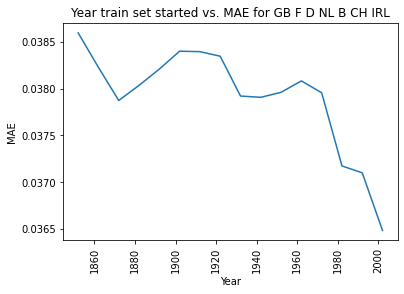

In [17]:
best_model, maes = find_best_year(raw, country_mask, COUNTRY_NAME_LIST)

## Model Analysis

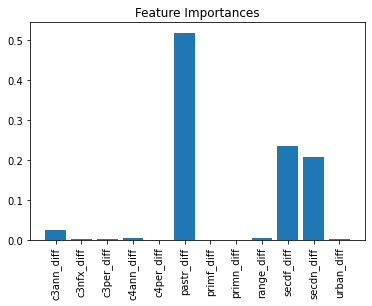

In [18]:
plt.bar(data["Train"]["X"].columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.show()

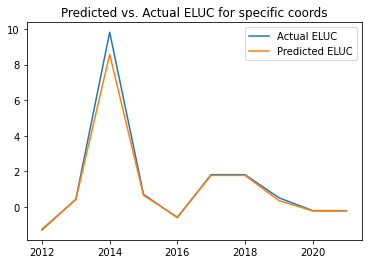

In [19]:
X_irl = data["Test"]["X"].loc[:, 54.125, -6.875]
y_irl = data["Test"]["y"].loc[:, 54.125, -6.875]

preds = model.predict(X_irl)

times = list(data["Test"]["X"].index.unique(level="time"))
plt.title("Predicted vs. Actual ELUC for specific coords")
plt.plot(times, y_irl, label="Actual ELUC")
plt.plot(times, preds, label="Predicted ELUC")
plt.legend()
plt.show()

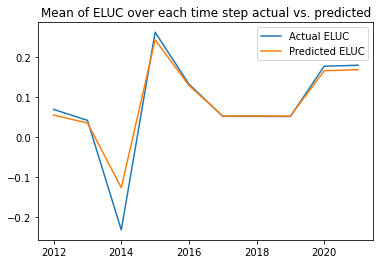

In [20]:
preds = model.predict(data["Test"]["X"])
test_copy = data["Test"]["X"].copy()
test_copy["pred"] = preds
test_copy["ELUC"] = data["Test"]["y"]
pred_eluc_sums = []
eluc_sums = []
for time in times:
    pred_eluc_sums.append(test_copy.loc[time, :, :]["pred"].mean())
    eluc_sums.append(test_copy.loc[time, :, :]["ELUC"].mean())

plt.title("Mean of ELUC over each time step actual vs. predicted")
plt.plot(times, eluc_sums, label="Actual ELUC")
plt.plot(times, pred_eluc_sums, label="Predicted ELUC")
plt.legend()
plt.show()